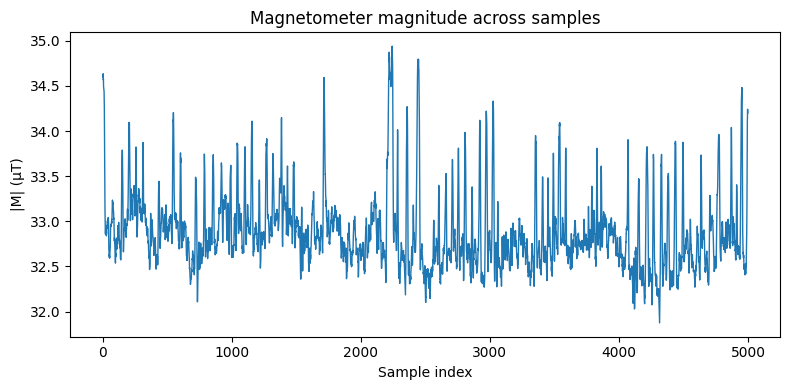


K-Means cluster centres:
  0:  Mx= 32.51,  My=  5.63,  Mz=  1.37
  1:  Mx= 31.86,  My=  3.42,  Mz= -6.53
K-Means sizes: [1624 3375]


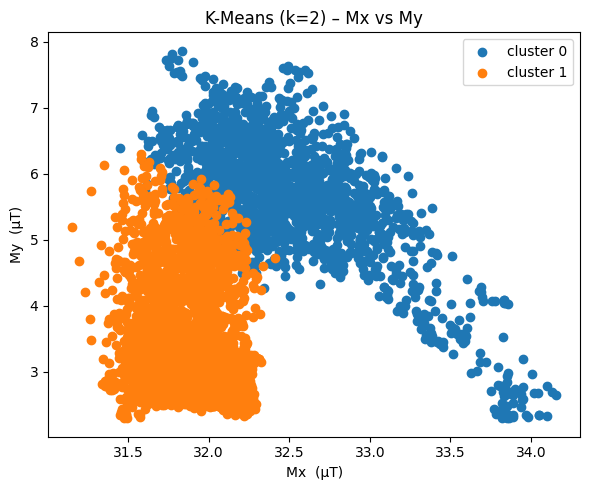

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# -------------------------------------------------
# 1. Load + tidy data
# -------------------------------------------------
df = pd.read_csv("magnetometer_labeled1.csv")
df = df.rename(columns={"Mx_mean": "Mx", "My_mean": "My", "Mz_mean": "Mz"})

# -------------------------------------------------
# 2. Compute field magnitude  |M| = sqrt(Mx²+My²+Mz²)
# -------------------------------------------------
df["M_mag"] = np.linalg.norm(df[["Mx", "My", "Mz"]].values, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(df.index, df["M_mag"],'-',linewidth=1.0)
plt.xlabel("Sample index")
plt.ylabel("|M| (µT)")
plt.title("Magnetometer magnitude across samples")
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 3. Feature scaling  (good practice for distance-based methods)
# -------------------------------------------------
scaler = StandardScaler()
X = scaler.fit_transform(df[["Mx", "My", "Mz"]])

# -------------------------------------------------
# 4-A. K-Means (k = 2)
# -------------------------------------------------
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
df["kmeans_label"] = kmeans.fit_predict(X)

# back-transform centres to original µT units
k_centres = scaler.inverse_transform(kmeans.cluster_centers_)
print("\nK-Means cluster centres:")
for i, c in enumerate(k_centres):
    print(f"  {i}:  Mx={c[0]:6.2f},  My={c[1]:6.2f},  Mz={c[2]:6.2f}")
print("K-Means sizes:", np.bincount(df["kmeans_label"]))

plt.figure(figsize=(6, 5))
for lab in np.unique(df["kmeans_label"]):
    mask = df["kmeans_label"] == lab
    plt.scatter(df.loc[mask, "Mx"], df.loc[mask, "My"], label=f"cluster {lab}")
plt.xlabel("Mx  (µT)")
plt.ylabel("My  (µT)")
plt.title("K-Means (k=2) – Mx vs My")
plt.legend()
plt.tight_layout()
plt.show()

K-Means centres: [32.74249633 33.70819328]
Saved plot: km_open_closed_plot_close1.png
Saved labeled data to magnetometer_labeled1.csv


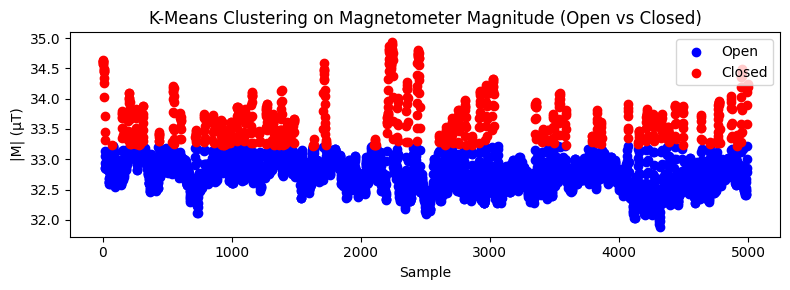

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load and preprocess the data
df = pd.read_csv("magnetometer_labeled1.csv")
df = df.rename(columns={'Mx_mean': 'Mx', 'My_mean': 'My', 'Mz_mean': 'Mz'})
df['M_mag'] = np.linalg.norm(df[['Mx', 'My', 'Mz']].values, axis=1)

# Standardize M_mag
mag = df['M_mag'].values.reshape(-1, 1)
sc = StandardScaler()
mag_z = sc.fit_transform(mag)

# Apply K-Means clustering
km = KMeans(n_clusters=2, n_init=10, random_state=42)
df['km'] = km.fit_predict(mag_z)
km_centers = sc.inverse_transform(km.cluster_centers_).ravel()
print("K-Means centres:", km_centers)

# Determine Open/Closed mapping based on cluster centers
if km_centers[0] > km_centers[1]:
    label_map = {0: "Closed", 1: "Open"}
else:
    label_map = {1: "Closed", 0: "Open"}
df['label'] = df['km'].map(label_map)

# Plot with label-based color and legend
plt.figure(figsize=(8, 3))
colors = df['label'].map({'Open': 'blue', 'Closed': 'red'})
for state in ['Open', 'Closed']:
    plt.scatter(
        df[df['label'] == state].index,
        df[df['label'] == state]['M_mag'],
        label=state,
        color='blue' if state == 'Open' else 'red'
    )

plt.xlabel('Sample')
plt.ylabel(r'|M| (µT)')
plt.title('K-Means Clustering on Magnetometer Magnitude (Open vs Closed)')
plt.legend()
plt.tight_layout()

# Save plot and labeled data
plt.savefig("km_open_closed_plot_close1.png")
print("Saved plot: km_open_closed_plot_close1.png")

df.to_csv("magnetometer_labeled1.csv", index=False)
print("Saved labeled data to magnetometer_labeled1.csv")

plt.show()

              precision    recall  f1-score   support

      Closed       1.00      1.00      1.00       143
        Open       1.00      1.00      1.00       857

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

[[143   0]
 [  0 857]]


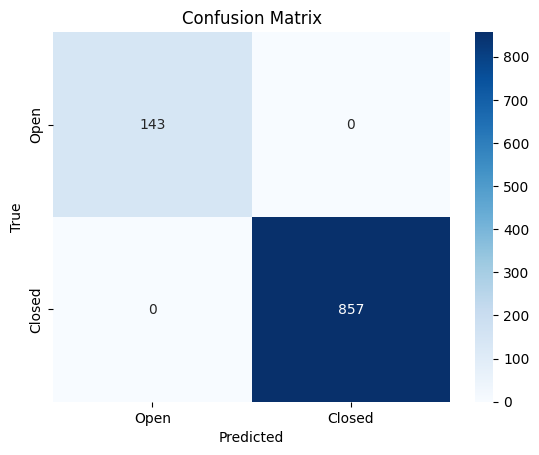

In [13]:
# model training

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the labeled data
df = pd.read_csv("magnetometer_labeled1.csv")
df = df.rename(columns={'Mx_mean': 'Mx', 'My_mean': 'My', 'Mz_mean': 'Mz'})
df['M_mag'] = np.linalg.norm(df[['Mx', 'My', 'Mz']].values, axis=1)

# Define features and target variable
X = df[['Mx', 'My', 'Mz', 'M_mag']]
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Open', 'Closed'], yticklabels=['Open', 'Closed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# save the model using m2cgen
import m2cgen as m2c

best_model = clf

model_code = m2c.export_to_c(best_model)
with open("decision_tree_model.h", "w") as f:
    f.write(model_code)
print("Model saved to decision_tree_model.h")

Model saved to decision_tree_model.h


Decision Tree Accuracy: 1.00
              precision    recall  f1-score   support

      Closed       1.00      1.00      1.00       143
        Open       1.00      1.00      1.00       857

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



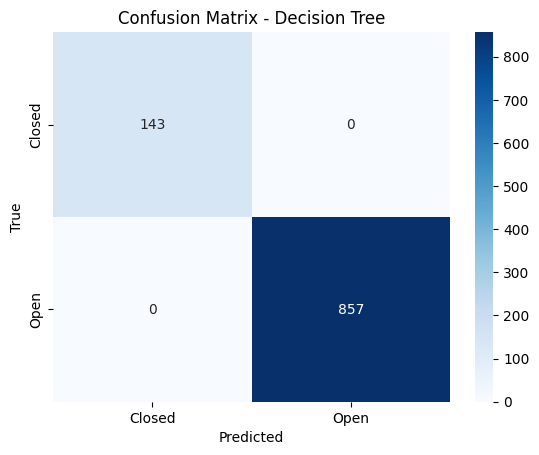



Random Forest Accuracy: 1.00
              precision    recall  f1-score   support

      Closed       0.99      1.00      1.00       143
        Open       1.00      1.00      1.00       857

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



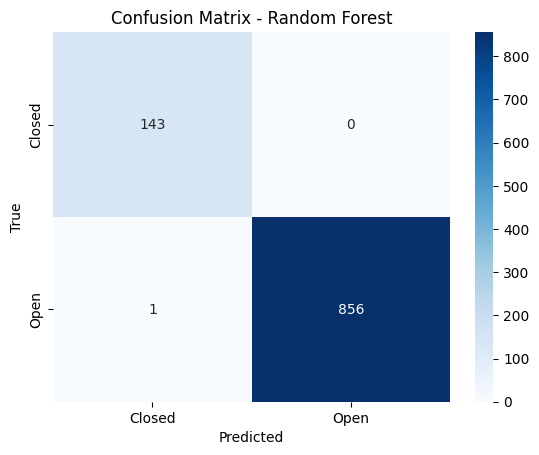



SVM Accuracy: 0.95
              precision    recall  f1-score   support

      Closed       0.86      0.79      0.82       143
        Open       0.97      0.98      0.97       857

    accuracy                           0.95      1000
   macro avg       0.91      0.88      0.90      1000
weighted avg       0.95      0.95      0.95      1000



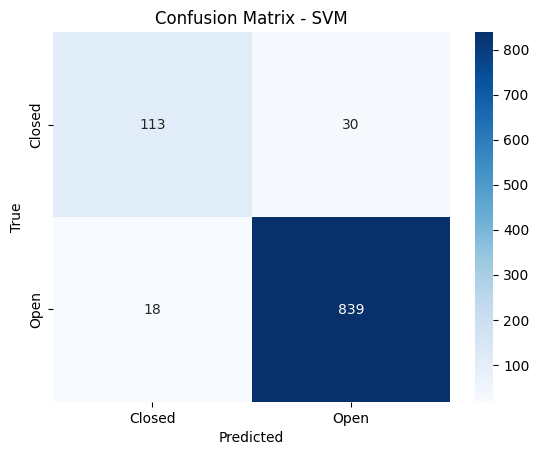



Logistic Regression Accuracy: 0.99
              precision    recall  f1-score   support

      Closed       0.98      0.93      0.95       143
        Open       0.99      1.00      0.99       857

    accuracy                           0.99      1000
   macro avg       0.98      0.96      0.97      1000
weighted avg       0.99      0.99      0.99      1000



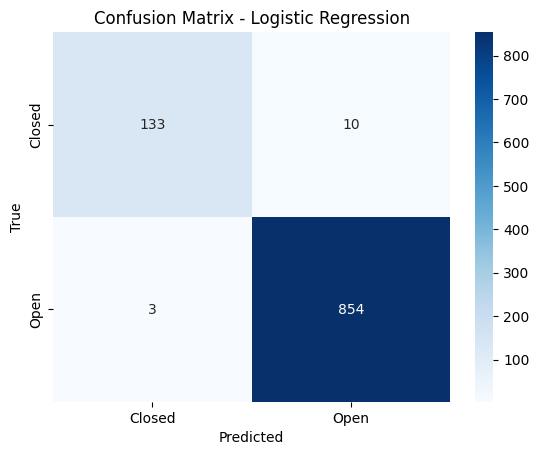

In [15]:
# build classical models like decision tree, SVM, Random Forest, and Logistic Regression ----- compare their performance and visualize the results and confuse matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Load the labeled data
df = pd.read_csv("magnetometer_labeled1.csv")
df = df.rename(columns={'Mx_mean': 'Mx', 'My_mean': 'My', 'Mz_mean': 'Mz'})
df['M_mag'] = np.linalg.norm(df[['Mx', 'My', 'Mz']].values, axis=1)

# Define features and target variable
X = df[['Mx', 'My', 'Mz', 'M_mag']]
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42)
}

# Train and evaluate each classifier
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'accuracy': accuracy,
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    print(f"{name} Accuracy: {accuracy:.2f}")
    print(results[name]['classification_report'])
    cm = results[name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    print("\n")

# Save the best model (Random Forest in this case) using m2cgen
import m2cgen as m2c

# best_model = classifiers['Random Forest']
# model_code = m2c.export_to_c(best_model)
# with open("random_forest_model.h", "w") as f:
#     f.write(model_code)
# print("Random Forest model saved to random_forest_model.h")

Epoch 1/50


c:\Users\New Fly High\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8395 - loss: 0.4804 - val_accuracy: 0.9500 - val_loss: 0.1734
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9528 - loss: 0.1626 - val_accuracy: 0.9475 - val_loss: 0.1576
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9497 - loss: 0.1571 - val_accuracy: 0.9488 - val_loss: 0.1588
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9565 - loss: 0.1475 - val_accuracy: 0.9488 - val_loss: 0.1713
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9553 - loss: 0.1451 - val_accuracy: 0.9500 - val_loss: 0.1533
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9501 - loss: 0.1586 - val_accuracy: 0.9488 - val_loss: 0.1683
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9622 - loss: 0.1250 - val_accuracy: 0.9500 - val_loss: 0.1488
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9578 - loss: 0.1352 - val_accuracy: 0.9488 - val_

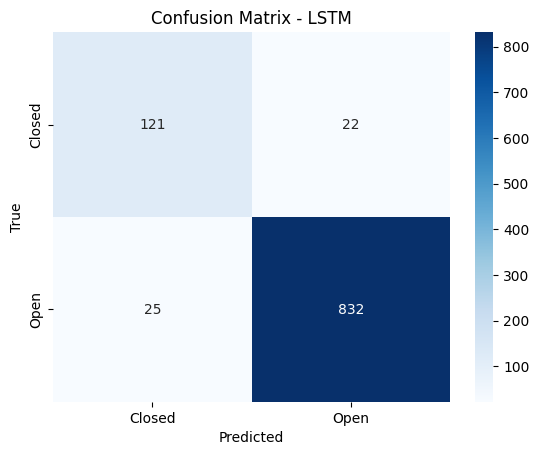

In [2]:
# build deep learning models like LSTM, CNN, and GRU ----- compare their performance and visualize the results and confuse matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Load the labeled data
df = pd.read_csv("magnetometer_labeled1.csv")
df = df.rename(columns={'Mx_mean': 'Mx', 'My_mean': 'My', 'Mz_mean': 'Mz'})
df['M_mag'] = np.linalg.norm(df[['Mx', 'My', 'Mz']].values, axis=1)

# Define features and target variable
X = df[['Mx', 'My', 'Mz', 'M_mag']].values
y = df['label'].values

# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Reshape X for LSTM input (samples, time steps, features)
X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model Accuracy: {accuracy:.2f}")
print(f"LSTM Model Loss: {loss:.2f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report and confusion matrix
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))
print(confusion_matrix(y_true_classes, y_pred_classes))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - LSTM')
plt.show()

Epoch 1/10


c:\Users\New Fly High\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8256 - loss: 0.8086 - val_accuracy: 0.9525 - val_loss: 0.1686
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8992 - loss: 0.2650 - val_accuracy: 0.9463 - val_loss: 0.1549
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9270 - loss: 0.2031 - val_accuracy: 0.9475 - val_loss: 0.1606
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9386 - loss: 0.1960 - val_accuracy: 0.9525 - val_loss: 0.1424
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9406 - loss: 0.1847 - val_accuracy: 0.9513 - val_loss: 0.1475
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9565 - loss: 0.1519 - val_accuracy: 0.9500 - val_loss: 0.1512
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9526 - loss: 0.1631 - val_accuracy: 0.9463 - val_loss: 0.1648
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9476 - loss: 0.1556 - val_accuracy: 0.9500 - val_

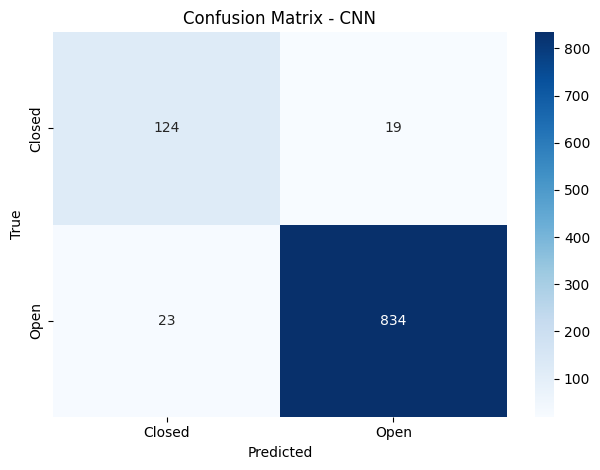

CNN model saved to cnn_model.h5


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# ------------------------------------------------------------------
# 1. Load your dataset
# ------------------------------------------------------------------
df = pd.read_csv("magnetometer_labeled1.csv")
X = df[["Mx", "My", "Mz", "M_mag"]].values
y = df["label"].values

# ------------------------------------------------------------------
# 2. Encode labels and one-hot encode
# ------------------------------------------------------------------
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# ------------------------------------------------------------------
# 3. Reshape and split data
# ------------------------------------------------------------------
X_reshaped = X.reshape((-1, 4, 1))
X_train_reshaped, X_test_reshaped, y_train, y_test = train_test_split(
    X_reshaped, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)

# ------------------------------------------------------------------
# 4. Define 1D CNN model
# ------------------------------------------------------------------
model_cnn = Sequential()
model_cnn.add(Flatten(input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(y_train.shape[1], activation='softmax'))

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ------------------------------------------------------------------
# 5. Train the model
# ------------------------------------------------------------------
history_cnn = model_cnn.fit(X_train_reshaped, y_train, epochs=10, batch_size=32,
                            validation_split=0.2, verbose=1)

# ------------------------------------------------------------------
# 6. Evaluate the model
# ------------------------------------------------------------------
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"CNN Model Accuracy: {accuracy_cnn:.2f}")
print(f"CNN Model Loss: {loss_cnn:.2f}")

# ------------------------------------------------------------------
# 7. Generate predictions and confusion matrix
# ------------------------------------------------------------------
y_pred_cnn = model_cnn.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred_cnn, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Fix target names
target_names = [str(cls) for cls in label_encoder.classes_]

# Print evaluation report
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN')
plt.tight_layout()
plt.show()

# save model
model_cnn.save("cnn_model.h5")
print("CNN model saved to cnn_model.h5")


Epoch 1/50


c:\Users\New Fly High\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8830 - loss: 0.4932 - val_accuracy: 0.9762 - val_loss: 0.0707
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9750 - loss: 0.0596 - val_accuracy: 0.9900 - val_loss: 0.0321
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9847 - loss: 0.0396 - val_accuracy: 0.9962 - val_loss: 0.0174
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0230 - val_accuracy: 1.0000 - val_loss: 0.0113
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0178 - val_accuracy: 0.9975 - val_loss: 0.0121
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0143 - val_accuracy: 0.9975 - val_loss: 0.0084
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0124 - val_accuracy: 0.9987 - val_loss: 0.0066
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0146 - val_accuracy: 1.0000 - val_

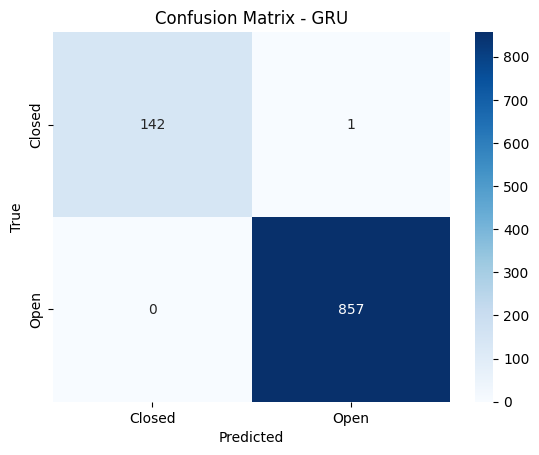

In [3]:

# GRU model

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# -------------------------------
# 1. Load and prepare data
# -------------------------------
df = pd.read_csv("magnetometer_labeled1.csv")
df["M_mag"] = np.linalg.norm(df[["Mx", "My", "Mz"]].values, axis=1)

X = df[["Mx", "My", "Mz", "M_mag"]].values
y = LabelEncoder().fit_transform(df["label"])
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df["label"])

# One-hot encode the target
y_categorical = to_categorical(y_encoded)

# Split
X_train, X_test, y_train_cat, y_test_cat = train_test_split(
    X, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for GRU
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# -------------------------------
# 2. Build and train GRU model
# -------------------------------
model_gru = Sequential()
model_gru.add(GRU(64, return_sequences=True, input_shape=(1, X_train.shape[1])))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, return_sequences=False))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(y_categorical.shape[1], activation='softmax'))

model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_gru = model_gru.fit(
    X_train_reshaped, y_train_cat,
    epochs=50, batch_size=32,
    validation_split=0.2, verbose=1
)

# -------------------------------
# 3. Evaluate GRU model
# -------------------------------
loss_gru, accuracy_gru = model_gru.evaluate(X_test_reshaped, y_test_cat, verbose=0)
print(f"GRU Model Accuracy: {accuracy_gru:.2f}")
print(f"GRU Model Loss: {loss_gru:.2f}")

# -------------------------------
# 4. Predict and visualize
# -------------------------------
y_pred_gru = model_gru.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred_gru, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - GRU')
plt.show()


In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

# ----------------------------------------------
# 1. Load your dataset
# ----------------------------------------------
df = pd.read_csv("magnetometer_labeled1.csv")
df["M_mag"] = np.linalg.norm(df[["Mx", "My", "Mz"]].values, axis=1)
X = df[["Mx", "My", "Mz", "M_mag"]].values
y = LabelEncoder().fit_transform(df["label"])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for 1D CNN (samples, time_steps=4, channels=1)
X_scaled = X_scaled.reshape((-1, 4, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# ----------------------------------------------
# 2. Load your trained CNN model (h5 format)
# ----------------------------------------------
model = load_model("cnn_model.h5")  # This should be your trained CNN_1D

# Optional: check float32 baseline accuracy
y_prob = model.predict(X_test)[:, 0]
y_pred = (y_prob > 0.5).astype(int)
from sklearn.metrics import accuracy_score, roc_auc_score
print("✅ Float Model - Accuracy:", accuracy_score(y_test, y_pred))
print("✅ Float Model - AUC:", roc_auc_score(y_test, y_prob))

# ----------------------------------------------
# 3. Create representative dataset generator
# ----------------------------------------------
def rep_data_gen():
    for i in range(0, len(X_train), 128):
        yield [X_train[i:i+128].astype(np.float32)]

# ----------------------------------------------
# 4. Convert to INT8 quantized TFLite model
# ----------------------------------------------
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = rep_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quant_model = converter.convert()

# Save to file
with open("cnn_1d_int8.tflite", "wb") as f:
    f.write(tflite_quant_model)

print("✅ INT8 model saved to cnn_1d_int8.tflite")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✅ Float Model - Accuracy: 0.003
✅ Float Model - AUC: 2.4479604409592688e-05
INFO:tensorflow:Assets written to: C:\Users\NEWFLY~1\AppData\Local\Temp\tmp8g2vgckz\assets


INFO:tensorflow:Assets written to: C:\Users\NEWFLY~1\AppData\Local\Temp\tmp8g2vgckz\assets


Saved artifact at 'C:\Users\NEWFLY~1\AppData\Local\Temp\tmp8g2vgckz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1650272752592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1650272749520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1650272751440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1650272752784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1650272748560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1650272750672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1650272751632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1650272747600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1650372454224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1650372452496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1650272750

c:\Users\New Fly High\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ INT8 model saved to cnn_1d_int8.tflite
